# FaceScape Bilinear Model - generate random 3D face

This demo shows how to use FaceScape bilinear model to generate randmom 3D meshes. Please make sure the environmenthave been prepared following [README-toolkit](https://github.com/zhuhao-nju/facescape/blob/master/toolkit/README.md).

### (1) demo for version 1.6

Please download **'facescape_bilinear_model_v1.6.zip'** from [FaceScape website](https://facescape.nju.edu.cn/) or from the [external_link](https://github.com/zhuhao-nju/facescape_debug/blob/master/doc/external_link_fsbm.md), then extract the npz files to "/toolkit/bilinear_model_v1.6/".  Here is a demo for the basic usage:

Results saved to './demo_output/'


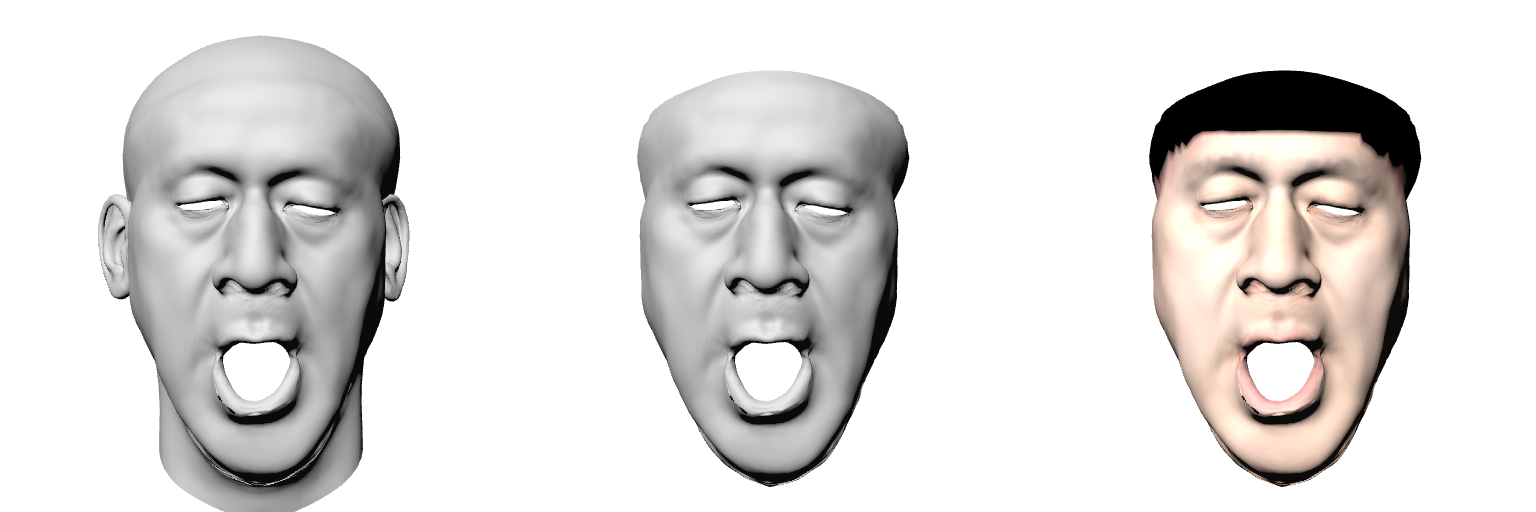

In [1]:
import numpy as np, trimesh
from src.facescape_bm import facescape_bm
from src.renderer import render_cvcam
from src.utility import show_img_arr

np.random.seed(1000)

model = facescape_bm("./bilinear_model_v1.6/facescape_bm_v1.6_847_50_52_id_front.npz")

# create random identity vector
random_id_vec = (np.random.random(50) - 0.5) * 0.1
if random_id_vec[0]>0:
    random_id_vec = -random_id_vec
    
# create random expression vector
exp_vec = np.zeros(52)
exp_vec[np.random.randint(52)] = 1
    
# creat random color vector
random_color_vec = (np.random.random(100) - 0.5) * 100

# generate and save full head mesh
mesh_full = model.gen_full(random_id_vec, exp_vec)
mesh_full.export("./demo_output/bm_v16_result_full.obj")

# generate and save facial mesh
mesh_face = model.gen_face(random_id_vec, exp_vec)
mesh_face.export("./demo_output/bm_v16_result_face.obj")

# generate and save facial mesh with rough vertex color
mesh_face_color = model.gen_face_color(random_id_vec, exp_vec, random_color_vec)
mesh_face_color.export("./demo_output/bm_v16_result_face_color.obj", enable_vc = True)

print("Results saved to './demo_output/'")

# render generated meshes
Rt = np.array([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 500]], dtype=np.float64)

depth_full, image_full = render_cvcam(trimesh.Trimesh(vertices = mesh_full.vertices, 
                                                      faces = mesh_full.faces_v-1),
                                      Rt = Rt)

depth_face, image_face = render_cvcam(trimesh.Trimesh(vertices = mesh_face.vertices, 
                                                      faces = mesh_face.faces_v-1),
                                      Rt = Rt)

depth_face_color, image_face_color = render_cvcam(trimesh.Trimesh(
                                             vertices = mesh_face_color.vertices, 
                                             faces = mesh_face_color.faces_v-1,
                                             vertex_colors = mesh_face_color.vert_colors),
                                                  Rt = Rt)

# show rendered images
merge_img = np.concatenate((image_full, image_face, image_face_color), 1)

show_img_arr(merge_img, bgr_mode = True)

**Generate random 3D faces.** If you hope to generate random faces that are not wierd, you should make the identity vectors follow the Gaussian distribution, with the provided mean and variance value. Here is a demo to generate 10 random and common 3D faces:

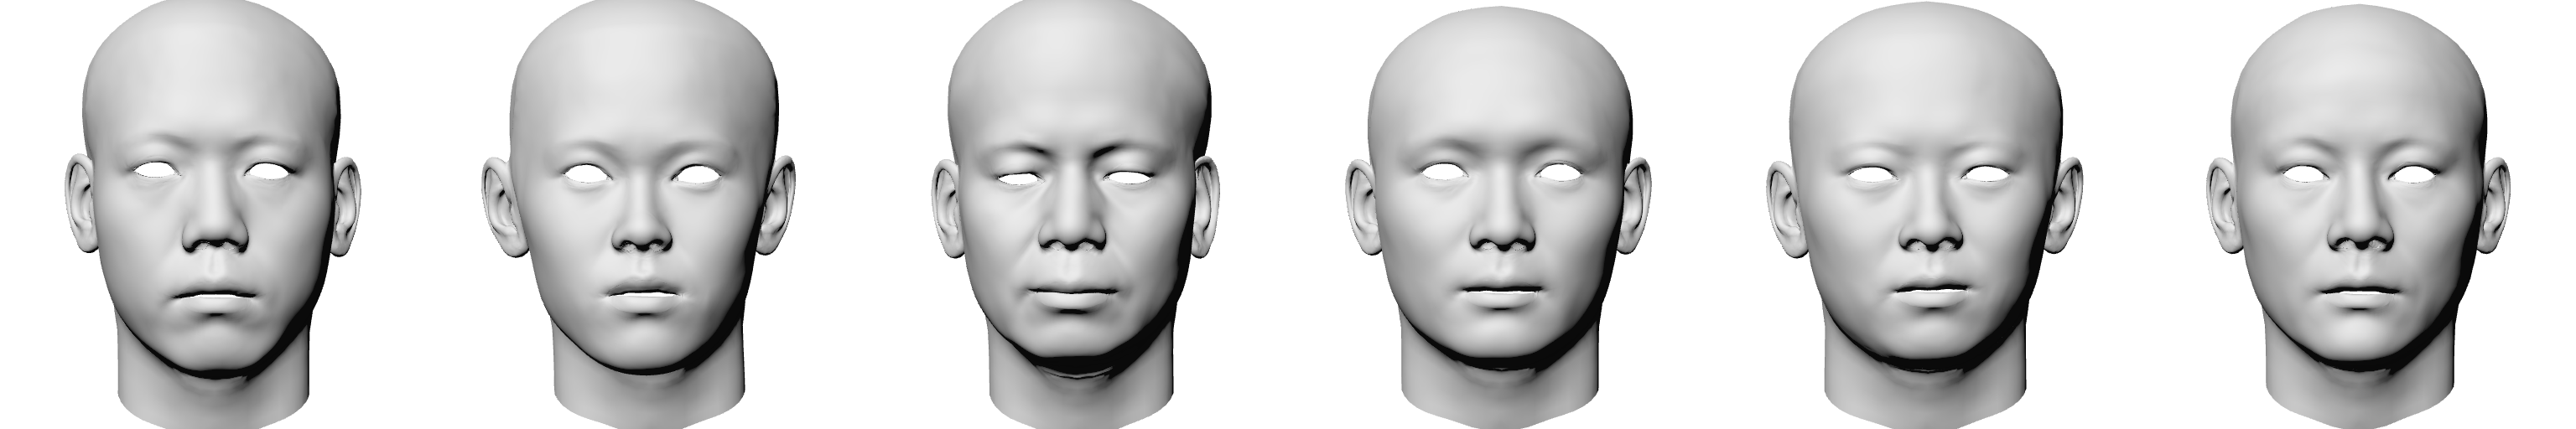

In [2]:
# new Rt for rendering
Rt = np.array([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 1000]], dtype=np.float64)

random_faces_list = []
for i in range(6):
    # create random identity vector
    random_id_vec = np.random.normal(model.id_mean, np.sqrt(model.id_var))
    
    # create random expression vector
    exp_vec = np.zeros(52)
    exp_vec[0] = 1

    # generate full head mesh
    mesh_full = model.gen_full(random_id_vec, exp_vec)

    # render
    depth_full, image_full = render_cvcam(trimesh.Trimesh(vertices = mesh_full.vertices, 
                                                      faces = mesh_full.faces_v-1),
                                          Rt = Rt)

    random_faces_list.append(image_full)

# show rendered images
merge_faces_img = np.concatenate(random_faces_list, 1)
show_img_arr(merge_faces_img, bgr_mode = True)

### (2) demo for Bilinear model v1.0/1.2/1.3

Please firstly download **'facescape_bilinear_model_v1.3.zip'** from [FaceScape website](https://facescape.nju.edu.cn/), extract the 'data' folder to the current directory, then run:

In [2]:
import numpy as np
import pickle, os

# triangle faces
with open('./data/predef_front_faces.pkl', 'rb') as f:
    faces_front = pickle.load(f)

with open('./data/front_indices.pkl', 'rb') as f:
    indices_front = pickle.load(f)
    
with open('./data/predef_faces.pkl', 'rb') as f:
    faces_full = pickle.load(f)
    
# texture coordinates
with open('./data/predef_texcoords.pkl', 'rb') as f:
    texcoords = pickle.load(f)

# bilinear model with 52 expression parameters and 50 identity parameters
# We perform Tucker decomposition only along the identity dimension to reserve the semantic meaning of parameters in expression dimension as speciﬁc blendshape weights
core_tensor = np.load('./data/core_847_50_52.npy')
factors_id = np.load('./data/factors_id_847_50_52.npy')

matrix_tex = np.load('./data/matrix_text_847_100.npy')
mean_tex = np.load('./data/mean_text_847_100.npy')
factors_tex = np.load('./data/factors_tex_847_100.npy')

id = factors_id[0]
exp = np.zeros(52)
exp[0] = 1

core_tensor = core_tensor.transpose((2, 1, 0))
mesh_vertices_full = core_tensor.dot(id).dot(exp).reshape((-1, 3))
mesh_vertices_front = mesh_vertices_full[indices_front]

tex = mean_tex + matrix_tex.dot(factors_tex[0])
tex = tex.reshape((-1, 3)) / 255

os.makedirs("./demo_output/", exist_ok = True)
with open('./demo_output/bm_v10_result_full.obj', "w") as f:
    for i in range(mesh_vertices_full.shape[0]):
        f.write("v %.6f %.6f %.6f\n" % (mesh_vertices_full[i, 0], mesh_vertices_full[i, 1], mesh_vertices_full[i, 2]))
    for i in range(len(texcoords)):
        f.write("vt %.6f %.6f\n" % (texcoords[i][0], texcoords[i][1]))
    for face in faces_full:
        face_vertices, face_normals, face_texture_coords, material = face
        f.write("f %d/%d %d/%d %d/%d\n" % (
            face_vertices[0], face_texture_coords[0], face_vertices[1], face_texture_coords[1], face_vertices[2],
            face_texture_coords[2]))

with open('./demo_output/bm_v10_result_face_color.obj', "w") as f:
    for i in range(mesh_vertices_front.shape[0]):
        f.write("v %.6f %.6f %.6f %.6f %.6f %.6f\n" % (
            mesh_vertices_front[i, 0], mesh_vertices_front[i, 1], mesh_vertices_front[i, 2], tex[i, 2], tex[i, 1], tex[i, 0]))
    for face in faces_front:
        face_vertices, face_normals, face_texture_coords, material = face
        f.write("f %d %d %d\n" % (face_vertices[0], face_vertices[1], face_vertices[2]))
print("Results saved to './demo_output/'")

Results saved to bilinear_result_head.obj and bilinear_result_face_color.obj
